# Business Intelligence Data Challenge

Usually when you sell something in the internet, the user/customer comes multiple times (e.g. visits) to the site, often also via different channels (e.g. Email, Facebook, Google, etc.), before he or she buys something (a conversion or transaction). In this analysis we try to explore the insights behind the conversion and explore the conversion on the basis of the attributed conversion fraction (IHC_Conv). Attributed conversion fraction is the fraction of the given conversion, which is attributed to a certain channel, sums up to 1.0 for every conversion.

## Datasets

**table_A_conversions.csv**:
* example list of conversions/ sales/ transaction
* Conv_ID - transaction ID
* Conv_Date - transaction date
* Revenue - value of transaction
* User_ID - an ID of a customer

**table_B_attribution.csv**:
* list of attribution results for conversions
* Conv_ID - transaction ID (link to table A)
* Channel - marketing channel
* IHC_Conv - attributed conversion fraction by the IHC model

In [1]:
#import the libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
from datetime import datetime
import ipywidgets as widgets
from IPython import display

%matplotlib inline
sns.set_style('whitegrid')
color = sns.color_palette()

In [2]:
#import the csv files
df_A = pd.read_csv("table_A_conversions.csv") 
df_B = pd.read_csv("table_B_attribution.csv") 

In [3]:
def create_hbox(dataframe_1,dataframe_2):
    """Helps in visualizing
       dataframe_1 and dataframe_2
       next to each other. 
    """
    # create output widgets
    widget1 = widgets.Output()
    widget2 = widgets.Output()

    # render in output widgets
    with widget1:
        display.display(dataframe_1)
    with widget2:
        display.display(dataframe_2)

    # create HBox
    hbox = widgets.HBox([widget1, widget2])

    # render hbox
    return hbox

In [4]:
#display the two csv files
display1 = create_hbox(df_A.head(10),df_B.head(10))
display1

**"table_A_conversions"**<br>
file can be seen having missing values for "User_ID" and also repeated values as a single user might have done multiple conversions, the "Conv_ID" here seems to be having unique values as it represents each conversions<br>
<br>
**"table_B_attribution"**<br> 
shows channels visited by a user before conversion

## Data Cleaning

In [5]:
# Getting Data Info, print a short summary of the dataframe
create_hbox(df_A.describe(),df_B.describe())

In [6]:
# Round off Revenue and IHC_Conv to 2 decimal digit
df_A['Revenue']  = df_A['Revenue'].round(decimals=2)
df_B['IHC_Conv'] = df_B['IHC_Conv'].round(decimals=2)

In [7]:
# Checking if the columns in dataframes hold unique values
def unique_col(dataframe1):
    dict_A ={}
    for col in dataframe1.columns: 
        dict_A[col] = dataframe1[col].is_unique

    return pd.DataFrame([dict_A])

create_hbox(unique_col(df_A),unique_col(df_B))

In [8]:
# Checking if the customers other than nan values are unique
User_ID_remove_nan = df_A["User_ID"].dropna()
User_ID_remove_nan.is_unique

False

In [9]:
# Converting User_ID to digits, nan values are assigned digit 2.
def str_to_int(dataframe_col,dict_empty):
    """
    str_to_int    - Converts the strings in the column to integer value,
                    makes it easier to understand a column.
    Takes 2 arguments:
    dataframe_col - A dataframe column whose values needs to be converted to a string.
    dict_empty    - It is an empty dictionary if the column names are not dependent 
                    on any other tables.
                    It is a dictionary containing key values as column (string values) 
                    from dependent table and value as its equivalent integer value.
    returns       - 'dataframe_col' - converted 'dataframe_col' from string to integer
                    'dict_temp'     - a dictionary with key as string values and value
                                      as the equivalent integer.
    """
    
    dict_temp = dict_empty
    if not bool(dict_temp): 
        count = 1
        for i in range (0,len(dataframe_col.tolist())):
            if dataframe_col[i] in dict_temp.keys(): 
                continue 
            else: 
                dict_temp[dataframe_col[i]] = count
                count = count+1

    list_temp =[]
    for i in range (0,len(dataframe_col.tolist())):
        list_temp.append(dict_temp[dataframe_col[i]]) 
    
    dataframe_col = list_temp
    return dataframe_col,dict_temp

In [10]:
# Converting User_ID to digits, nan values are assigned digit 2.
df_A["User_ID"], dict_A_temp1 = str_to_int(df_A["User_ID"],{})
df_A["Conv_ID"], dict_A_temp2 = str_to_int(df_A["Conv_ID"],{})
df_B["Conv_ID"], dict_B_temp1 = str_to_int(df_B["Conv_ID"],dict_A_temp2)

create_hbox(df_A.head(10),df_B.head(10))

### Add the columns - Year, Month, Day to the dataframe

In [11]:
# change the Conv_Date format - String to Timestamp format
df_A['Conv_Date'] = pd.to_datetime(df_A.Conv_Date, format='%d-%m-%Y')

# Add year_month, month and day columns to the dataframe
df_A.insert(loc=2, column='year_month', value=df_A.Conv_Date.map(lambda x: 100*x.year + x.month))
df_A.insert(loc=3, column='month',      value=df_A.Conv_Date.dt.month)
df_A.insert(loc=4, column='day',        value=(df_A.Conv_Date.dt.dayofweek)+1)
# The day here refers to the day of the week for example 1-Monday, 2-Tuesday.....

df_A.head()

,Conv_Date,Revenue,year_month,month,day,User_ID,Conv_ID
0,2017-03-06,47.00,201703,3,1,1,1
1,2017-03-02,98.00,201703,3,4,2,2
2,2017-03-02,180.35,201703,3,4,2,3
3,2017-03-23,201.94,201703,3,4,3,4
4,2017-03-03,197.47,201703,3,5,2,5


## Exploratory Data Analysis (EDA)
### Total Revenue made by each customer?

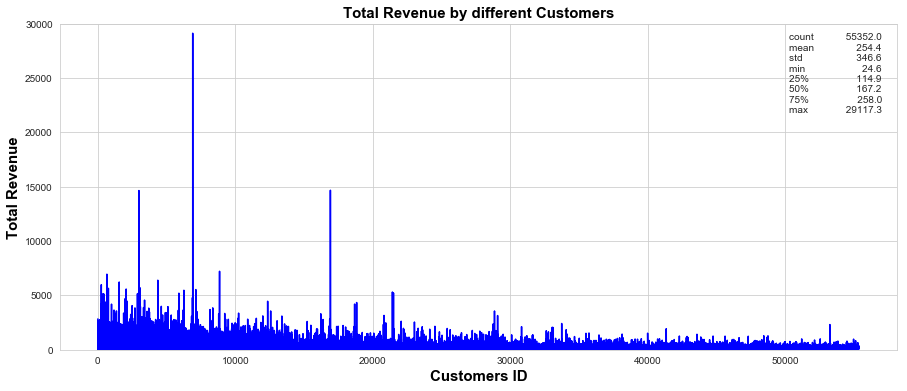

In [12]:
# Visualizing total revenue by customers.
temp_df = df_A.groupby(['User_ID'],as_index=False)['Revenue'].sum()
temp_df = temp_df.drop([1]) # User_ID 2 refers to all the customer id with nan values.


def describe_helper(series):
    """
    describe_helper - Takes a pandas series as an input and acts as a helping function
                      to plot the statistics in a matplotlib plot
    Takes 1 input arument:
    series          - A pandas series.
    
    returns         - keys and values which is a string
    """
    splits = str(series.describe().round(1)).split()
    splits = splits[0:16]
    keys, values = "", ""
    for i in range(0, len(splits), 2):
        keys += "{:8}\n".format(splits[i])
        values += "{:>8}\n".format(splits[i+1])
    return keys, values

plt.subplots(figsize=(15,6))
plt.plot(temp_df.User_ID,  temp_df.Revenue, color = 'blue')
plt.xlabel('Customers ID', fontsize=15, weight = 'bold', color="black")
plt.ylabel('Total Revenue',fontsize=15, weight = 'bold', color="black")
plt.title('Total Revenue by different Customers',fontsize=15, weight = 'bold', color="black")
plt.ylim([0, 30000])
plt.figtext(0.80,0.65, describe_helper(temp_df.Revenue)[0], {'multialignment':'left'})
plt.figtext(0.85,0.65, describe_helper(temp_df.Revenue)[1], {'multialignment':'right'})
plt.show()

### How many orders made by the customers?

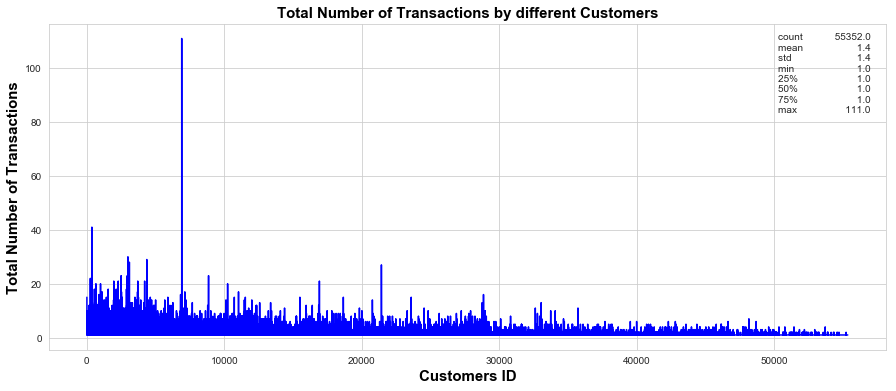

In [13]:
# Visualizing total revenue by customers.
temp_df1 = df_A.groupby(by='User_ID', as_index=False)['Conv_ID'].count()
temp_df1 = temp_df1.drop([1]) # User_ID 2 refers to all the customer id with nan values.

plt.subplots(figsize=(15,6))
plt.plot(temp_df1.User_ID, temp_df1.Conv_ID, color='blue')
plt.xlabel('Customers ID',fontsize=15, weight = 'bold', color="black")
plt.ylabel('Total Number of Transactions',fontsize=15, weight = 'bold', color="black")
plt.title('Total Number of Transactions by different Customers',fontsize=15, weight = 'bold', color="black")
plt.figtext(0.80,0.65, describe_helper(temp_df1.Conv_ID)[0], {'multialignment':'left'})
plt.figtext(0.85,0.65, describe_helper(temp_df1.Conv_ID)[1], {'multialignment':'right'})
plt.show()

### Comparing top 5 customers who made highest revenue to the ones who made highest transactions

In [14]:
x = temp_df.sort_values(by='Revenue', ascending=False).head(10)
y = temp_df1.sort_values(by='Conv_ID', ascending=False).head(10)
x.rename(columns={'Revenue': 'Total_Revenue'}, inplace=True)
y.rename(columns={'Conv_ID': 'Total_Conversions'}, inplace=True)
create_hbox(x, y)

### Number of Orders with respect to Months.

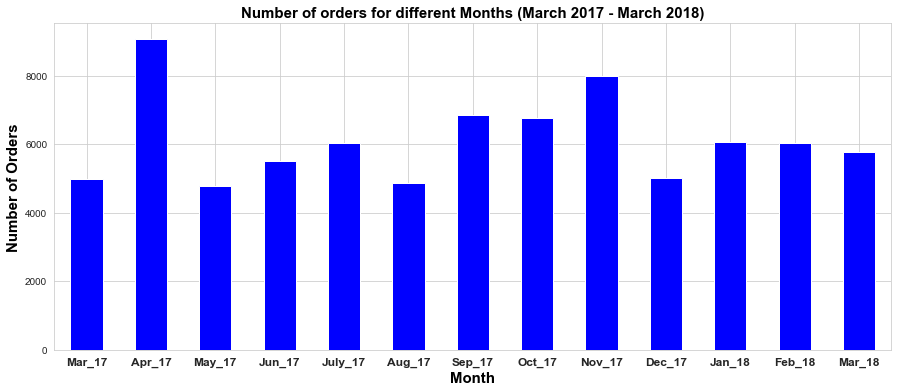

In [15]:
ax = df_A.groupby('Conv_ID')['year_month'].unique().value_counts().sort_index().plot('bar',color='blue',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Orders',fontsize=15, weight = 'bold', color="black")
ax.set_title('Number of orders for different Months (March 2017 - March 2018)',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(('Mar_17','Apr_17','May_17','Jun_17','July_17','Aug_17','Sep_17','Oct_17','Nov_17','Dec_17','Jan_18','Feb_18','Mar_18'), rotation='horizontal', fontsize=12, weight = 'bold')
plt.show()

### Total number of orders each day of the week

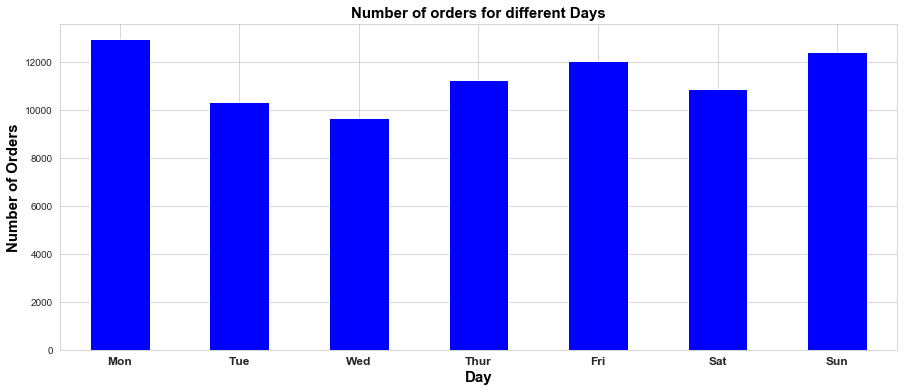

In [16]:
ax = df_A.groupby('Conv_ID')['day'].unique().value_counts().sort_index().plot('bar',color='blue',figsize=(15,6))
ax.set_xlabel('Day',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Orders',fontsize=15, weight = 'bold', color="black")
ax.set_title('Number of orders for different Days',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sat','Sun'), rotation='horizontal', fontsize=12, weight = 'bold')
plt.show()

## Cohort Analysis
### 1. Cohort Analysis - Retention Rate

In [17]:
###
#     1. Create a period column based on the Conv_Date
#     Since we're doing monthly cohorts, we'll be looking at the total monthly behavior 
#     of our users.
###

df_A_Cohort = df_A
df_A_Cohort['OrderPeriod'] = df_A_Cohort.Conv_Date.apply(lambda x: x.strftime('%Y-%m'))
df_A_Cohort.head()

,Conv_Date,Revenue,year_month,month,day,User_ID,Conv_ID,OrderPeriod
0,2017-03-06,47.00,201703,3,1,1,1,2017-03
1,2017-03-02,98.00,201703,3,4,2,2,2017-03
2,2017-03-02,180.35,201703,3,4,2,3,2017-03
3,2017-03-23,201.94,201703,3,4,3,4,2017-03
4,2017-03-03,197.47,201703,3,5,2,5,2017-03


In [18]:
###
#    2. Determine the user's cohort group (based on their first order)
#    Create a new column called CohortGroup, which is the year and month in which the user's 
#    first purchase occurred.
###

df_A_Cohort.set_index('User_ID', inplace=True)
df_A_Cohort['CohortGroup'] = df_A_Cohort.groupby(level=0)['Conv_Date'].min().apply(lambda x: x.strftime('%Y-%m'))
df_A_Cohort.reset_index(inplace=True)
df_A_Cohort.head()

,User_ID,Conv_Date,Revenue,year_month,month,day,Conv_ID,OrderPeriod,CohortGroup
0,1,2017-03-06,47.00,201703,3,1,1,2017-03,2017-03
1,2,2017-03-02,98.00,201703,3,4,2,2017-03,2017-03
2,2,2017-03-02,180.35,201703,3,4,3,2017-03,2017-03
3,3,2017-03-23,201.94,201703,3,4,4,2017-03,2017-03
4,2,2017-03-03,197.47,201703,3,5,5,2017-03,2017-03


In [19]:
###
#   3. Rollup data by CohortGroup & OrderPeriod
#   Since we're looking at monthly cohorts, we need to aggregate users, and amount 
#   spent by the CohortGroup within the month (OrderPeriod).
###

grouped = df_A_Cohort.groupby(['CohortGroup', 'OrderPeriod'])
# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'User_ID': pd.Series.nunique,
                       'Revenue': np.sum})
# make the column names more meaningful
cohorts.rename(columns={'User_ID': 'TotalUsers'}, inplace=True)
cohorts.head()

TotalUsers    Revenue
CohortGroup OrderPeriod                       
2017-03     2017-03            4449  958340.01
            2017-04            1048  298758.47
            2017-05             637  132266.80
            2017-06             569  128204.15
            2017-07             541  115876.69

In [20]:
###
#   4. Label the CohortPeriod for each CohortGroup
#   We want to look at how each cohort has behaved in the months following their first purchase, 
#   so we'll need to index each cohort to their first purchase month. For example,CohortPeriod=1 
#   will be the cohort's first month, CohortPeriod = 2 is their second, and so on.
#   This allows us to compare cohorts across various stages of their lifetime.
###

def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    Example: Say you want to get the 3rd month for every user:
           df.sort(['UserId', 'Revenue', inplace=True)
           df = df.groupby('UserId').apply(cohort_period)
           df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers    Revenue  CohortPeriod
CohortGroup OrderPeriod                                     
2017-03     2017-03            4449  958340.01             1
            2017-04            1048  298758.47             2
            2017-05             637  132266.80             3
            2017-06             569  128204.15             4
            2017-07             541  115876.69             5

In [21]:
###
#  5. Making sure everything is right using assert statement
#  testing the data points from the original DataFrame with their corresponding values in the new 
#  cohorts DataFrame to make sure all our data transformations worked as expected. As long as 
#  none of these raise an exception, it is good.
###

df = df_A_Cohort

x  = df[(df.CohortGroup == '2017-03') & (df.OrderPeriod == '2017-03')]
y  = cohorts.loc[('2017-03', '2017-03')]
assert(x['User_ID'].nunique()      == y['TotalUsers'])
assert(x['Revenue'].sum().round(2) == y['Revenue'].round(2))

x = df[(df.CohortGroup == '2017-03') & (df.OrderPeriod == '2017-09')]
y = cohorts.loc[('2017-03', '2017-09')]
assert(x['User_ID'].nunique()      == y['TotalUsers'])
assert(x['Revenue'].sum().round(2) == y['Revenue'].round(2))

x = df[(df.CohortGroup == '2017-07') & (df.OrderPeriod == '2017-09')]
y = cohorts.loc[('2017-07', '2017-09')]
assert(x['User_ID'].nunique()      == y['TotalUsers'])
assert(x['Revenue'].sum().round(2) == y['Revenue'].round(2))

In [22]:
###
#   6.User Retention by Cohort Group
#   We want to look at the percentage change of each CohortGroup over time and not the absolute 
#   change.
#   will first create a pandas Series containing each CohortGroup and its size.
###

# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2017-03    4449
2017-04    7266
2017-05    3190
2017-06    3794
2017-07    4058
Name: TotalUsers, dtype: int64

In [23]:
#unstacking the CohortGroup level from the index
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
CohortPeriod,,,,,,,,,,,,,
1,4449.0,7266.0,3190.0,3794.0,4058.0,3388.0,4519.0,4450.0,5173.0,3179.0,4010.0,4066.0,3811.0
2,1048.0,573.0,187.0,182.0,124.0,147.0,132.0,138.0,81.0,60.0,88.0,83.0,NaN
3,637.0,594.0,219.0,137.0,130.0,120.0,147.0,61.0,59.0,62.0,65.0,NaN,NaN
4,569.0,677.0,161.0,152.0,117.0,109.0,79.0,59.0,52.0,42.0,NaN,NaN,NaN
5,541.0,403.0,218.0,153.0,137.0,52.0,93.0,53.0,65.0,NaN,NaN,NaN,NaN


In [24]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
CohortPeriod,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.235559,0.078860,0.058621,0.047970,0.030557,0.043388,0.029210,0.031011,0.015658,0.018874,0.021945,0.020413,NaN
3,0.143178,0.081751,0.068652,0.036110,0.032035,0.035419,0.032529,0.013708,0.011405,0.019503,0.016209,NaN,NaN
4,0.127894,0.093174,0.050470,0.040063,0.028832,0.032172,0.017482,0.013258,0.010052,0.013212,NaN,NaN,NaN
5,0.121600,0.055464,0.068339,0.040327,0.033760,0.015348,0.020580,0.011910,0.012565,NaN,NaN,NaN,NaN
6,0.088559,0.099229,0.065204,0.043490,0.015278,0.017414,0.016154,0.014157,NaN,NaN,NaN,NaN,NaN
7,0.116206,0.107074,0.058934,0.021613,0.020946,0.017119,0.013720,NaN,NaN,NaN,NaN,NaN,NaN
8,0.105417,0.086843,0.042320,0.025303,0.015771,0.015643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.111710,0.045968,0.031661,0.023458,0.017250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


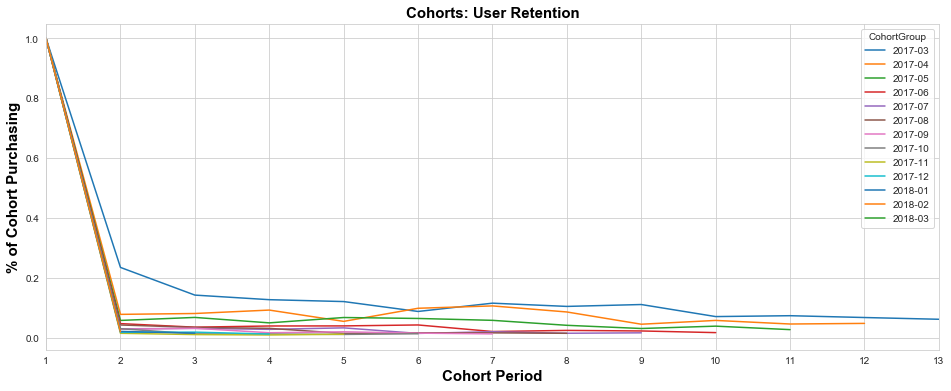

In [25]:
###
#   Finally, we can plot the cohorts over time in an effort to spot behavioral differences or 
#   similarities. Two common cohort charts are line graphs and heatmaps, both of which are shown 
#   below.
#   Notice that the first period of each cohort is 100% -- this is because our cohorts are based 
#   on each user's first purchase, meaning everyone in the cohort purchased in month 1.
###

user_retention[['2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03']].plot(figsize=(16,6))
plt.xticks(np.arange(1, 13.1, 1))
plt.xlim(1, 13)
plt.title('Cohorts: User Retention',fontsize=15, weight = 'bold', color="black")
plt.xlabel('Cohort Period',fontsize=15, weight = 'bold', color="black")
plt.ylabel('% of Cohort Purchasing',fontsize=15, weight = 'bold', color="black")
plt.show()

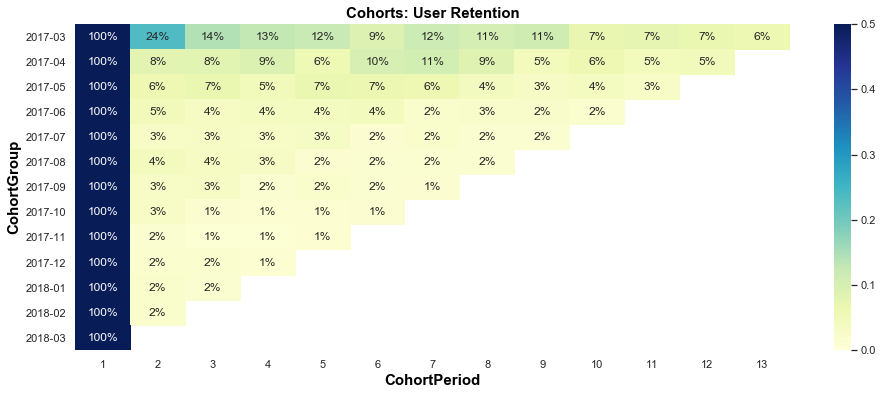

In [26]:
# Creating heatmaps.

import seaborn as sns
sns.set(style='white')
plt.figure(figsize=(16, 6))
plt.title('Cohorts: User Retention',fontsize=15, weight = 'bold', color="black")
plt.xlabel('Cohort Period',fontsize=15, weight = 'bold', color="black")
plt.ylabel('Cohort Group',fontsize=15, weight = 'bold', color="black")
plt.xlim(1, 13)
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = "YlGnBu")
plt.show()

### 2. Cohort Analysis - Revenue

In [27]:
cohort_group_size = cohorts['Revenue'].groupby(level=0).first()
user_revenue = cohorts['Revenue'].unstack(0).divide(cohort_group_size, axis=1)
user_revenue.head(10)

CohortGroup,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
CohortPeriod,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.311746,0.061129,0.072009,0.070704,0.038177,0.057191,0.037472,0.036550,0.018408,0.023642,0.027666,0.027405,NaN
3,0.138017,0.074485,0.082682,0.040633,0.038155,0.044484,0.041379,0.016908,0.012597,0.024118,0.018030,NaN,NaN
4,0.133777,0.082251,0.055000,0.063161,0.035425,0.039233,0.021299,0.014816,0.012496,0.015807,NaN,NaN,NaN
5,0.120914,0.044509,0.085824,0.053901,0.044404,0.021584,0.023183,0.014400,0.015658,NaN,NaN,NaN,NaN
6,0.087483,0.099493,0.082943,0.056327,0.020424,0.019330,0.020433,0.018263,NaN,NaN,NaN,NaN,NaN
7,0.129430,0.108985,0.072967,0.026339,0.031429,0.025525,0.015586,NaN,NaN,NaN,NaN,NaN,NaN
8,0.121422,0.079598,0.055028,0.027767,0.019704,0.020274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.199823,0.041876,0.036252,0.030414,0.021604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


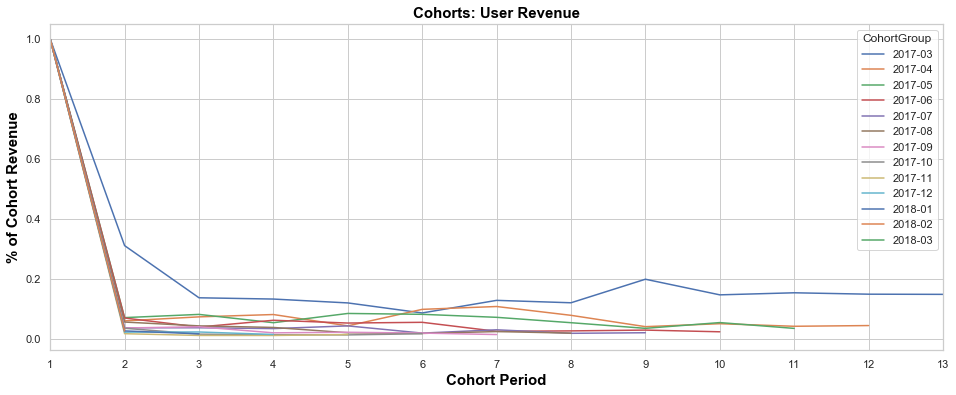

In [28]:
sns.set_style('whitegrid')
user_revenue[['2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03']].plot(figsize=(16,6))
plt.xticks(np.arange(1, 13.1, 1))
plt.xlim(1, 13)
plt.title('Cohorts: User Revenue',fontsize=15, weight = 'bold', color="black")
plt.xlabel('Cohort Period',fontsize=15, weight = 'bold', color="black")
plt.ylabel('% of Cohort Revenue',fontsize=15, weight = 'bold', color="black")
plt.show()

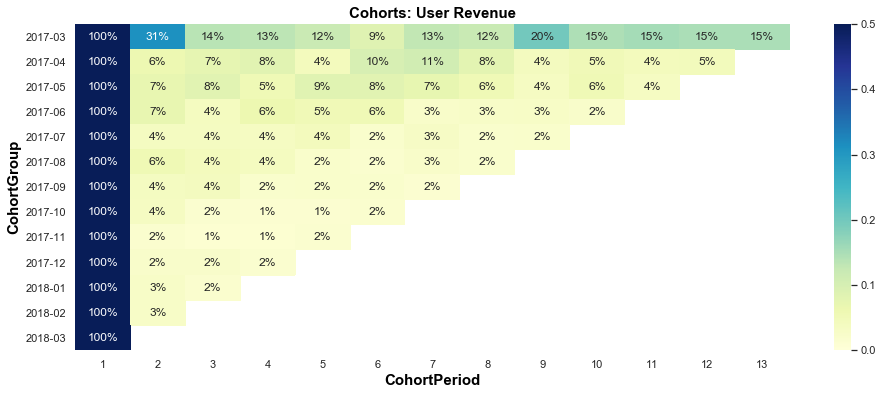

In [29]:
# Creating heatmaps.

import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(16, 6))
plt.title('Cohorts: User Revenue',fontsize=15, weight = 'bold', color="black")
plt.xlabel('Cohort Period',fontsize=15, weight = 'bold', color="black")
plt.ylabel('Cohort Group',fontsize=15, weight = 'bold', color="black")
plt.xlim(1, 13)
sns.heatmap(user_revenue.T, mask=user_revenue.T.isnull(), annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = "YlGnBu")
plt.show()

# Customer Statistics 

In [30]:
dict_first = {}
dict_last  = {}
dict_led_to_last = {}

for i in range (0,max(df_B["Conv_ID"].tolist())):
    # selecting rows based on condition 
    rslt_df = df_B[df_B['Conv_ID'] == i+1] 
    rslt_df = rslt_df.reset_index()
    number_of_rows = rslt_df.shape[0]
    if number_of_rows == 0:
        continue
    if number_of_rows == 1:
        dict_first[i+1] = rslt_df.loc[0,'Channel']
        dict_last[i+1]  = rslt_df.loc[0,'Channel']
        dict_led_to_last[i+1] = rslt_df.loc[0,'Channel']

    elif number_of_rows == 2:
        dict_first[i+1] = rslt_df.loc[0,'Channel']
        dict_last[i+1]  = rslt_df.loc[1,'Channel']
        dict_led_to_last[i+1] = rslt_df.loc[0,'Channel']
        
    else:
        dict_first[i+1] = rslt_df.loc[0,'Channel']
        dict_last[i+1]  = rslt_df.loc[number_of_rows-1,'Channel']
        dict_led_to_last[i+1] = rslt_df.loc[number_of_rows-2,'Channel']

In [31]:
first       = list(dict_first.values())
led_to_last = list(dict_led_to_last.values())
last        = list(dict_last.values())

repeat      = df_B.pivot_table(index=['Conv_ID'], aggfunc='size')
modified    = repeat.reset_index()
modified.columns  = ['Conv_ID', 'Number_of_Transactions']
modified['First'] = np.array(first)
modified['Led_to_last'] = np.array(led_to_last)
modified['Last']  = np.array(last)
modified.head()

,Conv_ID,Number_of_Transactions,First,Led_to_last,Last
0,1,1,H,H,H
1,2,3,I,A,E
2,3,1,H,H,H
3,4,7,I,K,E
4,5,1,I,I,I


### Customer Statistics - Conversion from single webpage

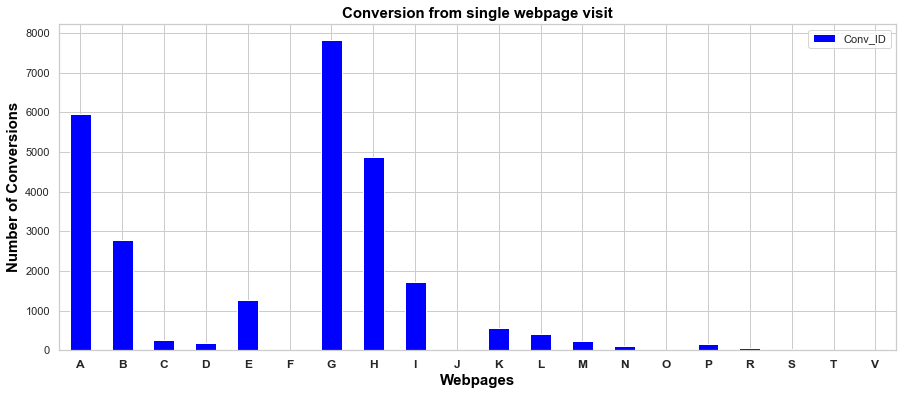

In [32]:
sns.set_style('whitegrid')
# selecting rows based on condition 
rslt_df = modified[modified['Number_of_Transactions'] == 1]

temp1 = rslt_df.groupby(by='First', as_index=False)['Conv_ID'].count()
ax = temp1.plot(kind='bar', color= 'blue',figsize=(15,6))
ax.set_xlabel('Webpages',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Conversions',fontsize=15, weight = 'bold', color="black")
ax.set_title('Conversion from single webpage visit',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(list(temp1.First), rotation='horizontal', fontsize=12, weight = 'bold')
plt.show()

### Customer Statistics - Conversion of last visited webpage
#### Including the webpages where conversion happened at the first webpage

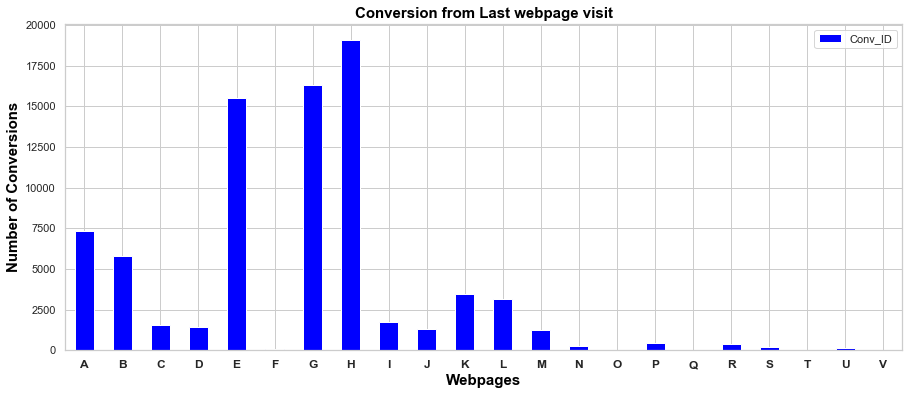

In [33]:
rslt_df1 = modified

temp2 = rslt_df1.groupby(by='Last', as_index=False)['Conv_ID'].count()
ax = temp2.plot(kind='bar', color= 'blue',figsize=(15,6))
ax.set_xlabel('Webpages',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Conversions',fontsize=15, weight = 'bold', color="black")
ax.set_title('Conversion from Last webpage visit',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(list(temp2.Last), rotation='horizontal', fontsize=12, weight = 'bold')
plt.show()

#### Excluding the webpages where conversion happened at the first webpage

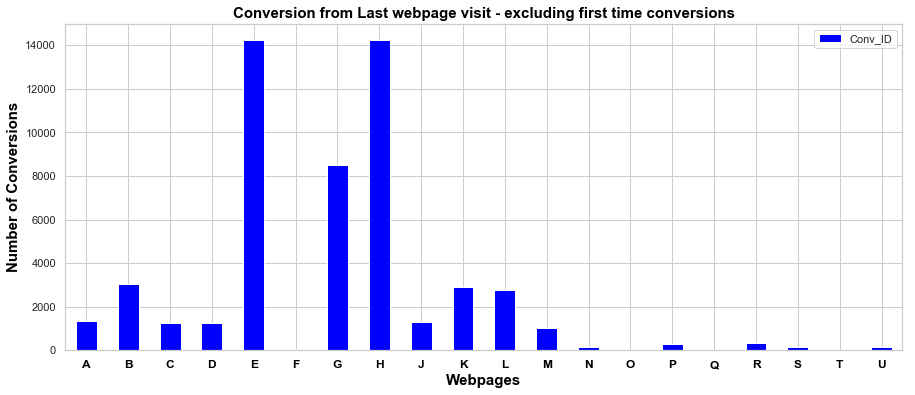

In [34]:
# selecting rows based on condition 
rslt_df2 = modified[modified['Number_of_Transactions'] != 1]

temp3 = rslt_df2.groupby(by='Last', as_index=False)['Conv_ID'].count()
ax = temp3.plot(kind='bar', color= 'blue',figsize=(15,6))
ax.set_xlabel('Webpages',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Conversions',fontsize=15, weight = 'bold', color="black")
ax.set_title('Conversion from Last webpage visit - excluding first time conversions',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(list(temp3.Last), rotation='horizontal',fontsize=12, weight = 'bold', color="black")
plt.show()

### Customer Statistics - Conversion of before to last visited webpage
#### Including the webpages where conversion happened at the first webpage

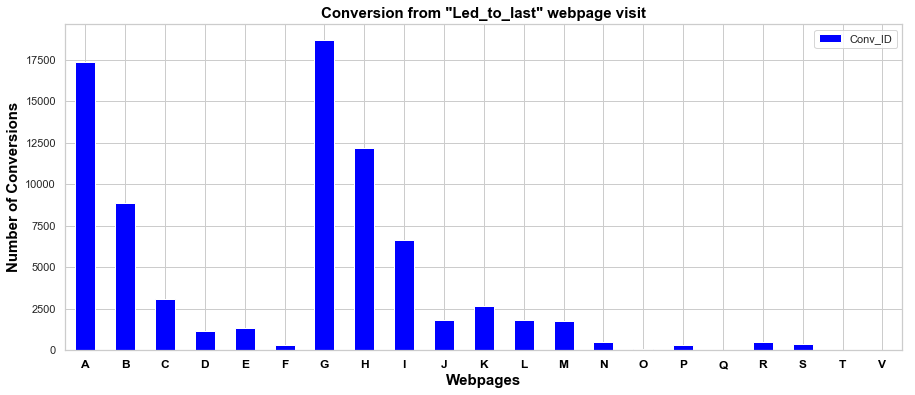

In [35]:
# selecting rows based on condition 
rslt_df3 = modified

temp4 = rslt_df3.groupby(by='Led_to_last', as_index=False)['Conv_ID'].count()
ax = temp4.plot(kind='bar', color= 'blue',figsize=(15,6))
ax.set_xlabel('Webpages',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Conversions',fontsize=15, weight = 'bold', color="black")
ax.set_title('Conversion from "Led_to_last" webpage visit',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(list(temp4.Led_to_last), rotation='horizontal', fontsize=12, weight = 'bold', color="black")
plt.show()

#### Excluding the webpages where conversion happened at the first webpage

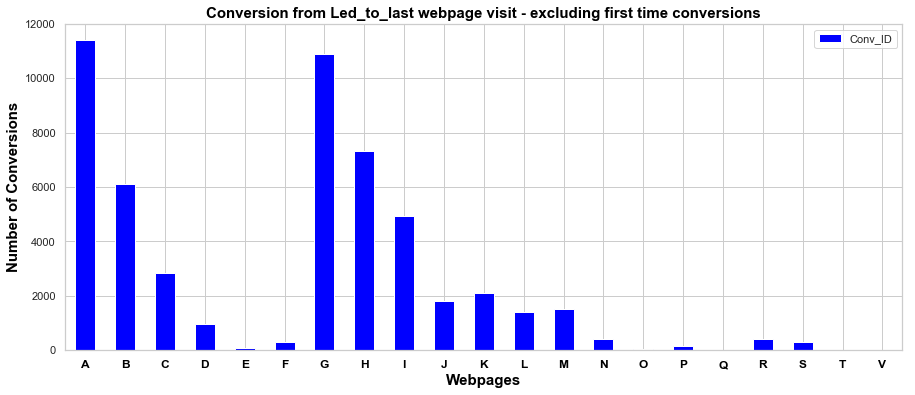

In [36]:
# selecting rows based on condition 
rslt_df4 = modified[modified['Number_of_Transactions'] != 1]

temp5 = rslt_df4.groupby(by='Led_to_last', as_index=False)['Conv_ID'].count()
ax = temp5.plot(kind='bar', color= 'blue',figsize=(15,6))
ax.set_xlabel('Webpages',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Conversions',fontsize=15, weight = 'bold', color="black")
ax.set_title('Conversion from Led_to_last webpage visit - excluding first time conversions',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(list(temp5.Led_to_last), rotation='horizontal', fontsize=12, weight = 'bold', color="black")
plt.show()

### Customer Statistics - Cumulative Contribution to Conversion by each webpage

In [37]:
df_inner = pd.merge(df_A, df_B, on='Conv_ID', how='inner')
df_inner.head(10)

,User_ID,Conv_Date,Revenue,year_month,month,day,Conv_ID,OrderPeriod,CohortGroup,Channel,IHC_Conv
0,1,2017-03-06,47.00,201703,3,1,1,2017-03,2017-03,H,1.00
1,2,2017-03-02,98.00,201703,3,4,2,2017-03,2017-03,I,0.30
2,2,2017-03-02,98.00,201703,3,4,2,2017-03,2017-03,A,0.32
3,2,2017-03-02,98.00,201703,3,4,2,2017-03,2017-03,E,0.38
4,2,2017-03-02,180.35,201703,3,4,3,2017-03,2017-03,H,1.00
5,3,2017-03-23,201.94,201703,3,4,4,2017-03,2017-03,I,0.18
6,3,2017-03-23,201.94,201703,3,4,4,2017-03,2017-03,A,0.57
7,3,2017-03-23,201.94,201703,3,4,4,2017-03,2017-03,B,0.02
8,3,2017-03-23,201.94,201703,3,4,4,2017-03,2017-03,G,0.06
9,3,2017-03-23,201.94,201703,3,4,4,2017-03,2017-03,H,0.15


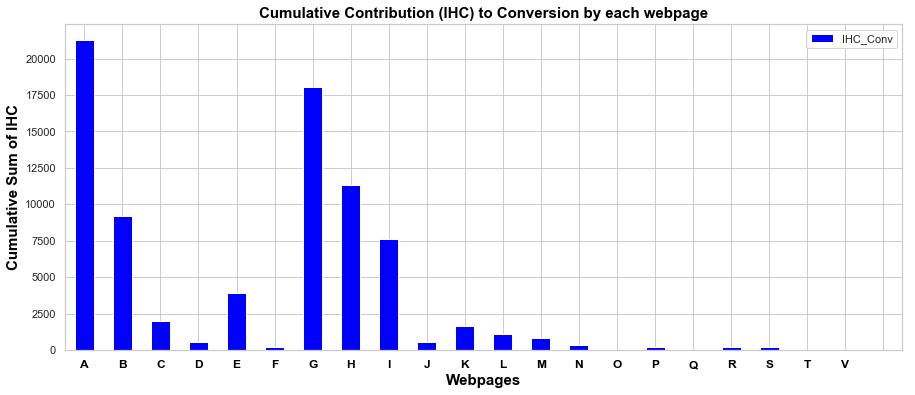

In [38]:
temp6 = df_inner.groupby(by='Channel', as_index=False)['IHC_Conv'].sum()
ax = temp6.plot(kind='bar', color= 'blue',figsize=(15,6))
ax.set_xlabel('Webpages',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Cumulative Sum of IHC',fontsize=15, weight = 'bold', color="black")
ax.set_title('Cumulative Contribution (IHC) to Conversion by each webpage',fontsize=15, weight = 'bold', color="black")
ax.set_xticklabels(list(temp5.Led_to_last), rotation='horizontal', fontsize=12, weight = 'bold', color="black")
plt.show()

## Customer Segmentation

In [39]:
dict_number_of_webpages = {}     #number of webpages visited before buying

for i in range (0,max(df_B["Conv_ID"].tolist())):
    # selecting rows based on condition 
    rslt_df = df_B[df_B['Conv_ID'] == i+1] 
    rslt_df = rslt_df.reset_index()
    number_of_rows = rslt_df.shape[0]
    
    if number_of_rows == 0:
        continue
    elif number_of_rows in dict_number_of_webpages.keys(): 
        dict_number_of_webpages[number_of_rows] = dict_number_of_webpages[number_of_rows] + 1
    else:
        dict_number_of_webpages[number_of_rows] = 1


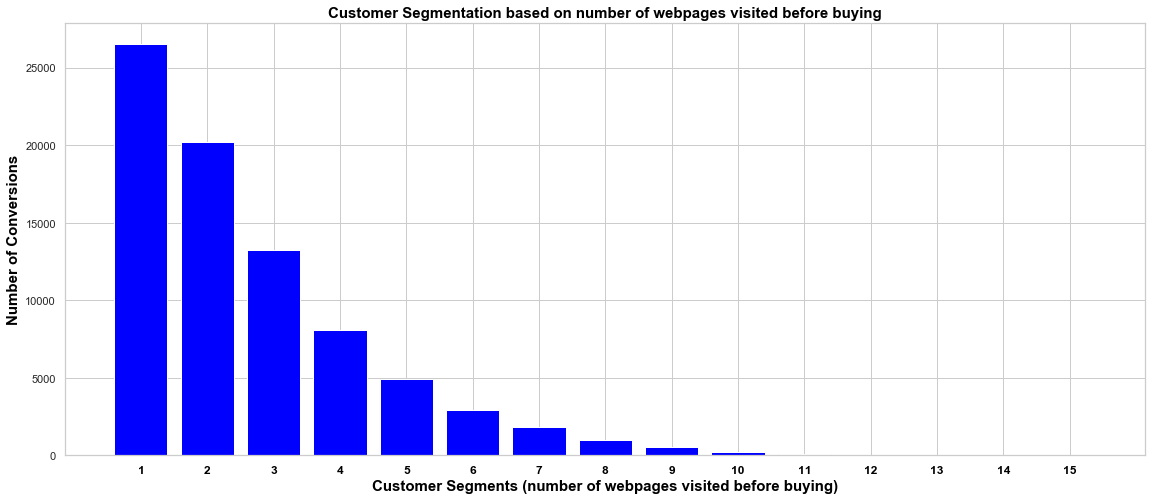

In [40]:
fig    = plt.figure(figsize=(15,6))
ax     = fig.add_axes([0,0,1,1])
x_axis = list(dict_number_of_webpages.keys())
y_axis = list(dict_number_of_webpages.values())
ax.bar(x_axis,y_axis,color='blue')
ax.set_xlabel('Customer Segments (number of webpages visited before buying)',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Conversions',fontsize=15, weight = 'bold', color="black")
ax.set_title('Customer Segmentation based on number of webpages visited before buying',fontsize=15, weight = 'bold', color="black")
plt.xticks(x_axis,fontsize=12, weight = 'bold', color="black")
plt.show()

In [41]:
dict_number_of_days = {}     #number of days before buying

def calculate_days(df1,df2):
    import numpy as np
    return int((df1 - df2)/np.timedelta64(1,'D'))

for i in range (0,max(df_inner["Conv_ID"].tolist())):
    # selecting rows based on condition 
    rslt_df = df_inner[df_inner['Conv_ID'] == i+1] 
    rslt_df = rslt_df.reset_index()
    number_of_rows = rslt_df.shape[0]
    
    if number_of_rows == 0:
        continue
    elif number_of_rows == 1: 
        if number_of_rows in dict_number_of_days.keys():
            dict_number_of_days[number_of_rows] = dict_number_of_days[number_of_rows] + 1
        else:
            dict_number_of_days[number_of_rows] = 1
    else:
        temp_days = calculate_days(rslt_df['Conv_Date'][number_of_rows-1],rslt_df['Conv_Date'][0])
        if temp_days in dict_number_of_days.keys():
            dict_number_of_days[temp_days] = dict_number_of_days[temp_days] + 1
        else:
            dict_number_of_days[temp_days] = 1

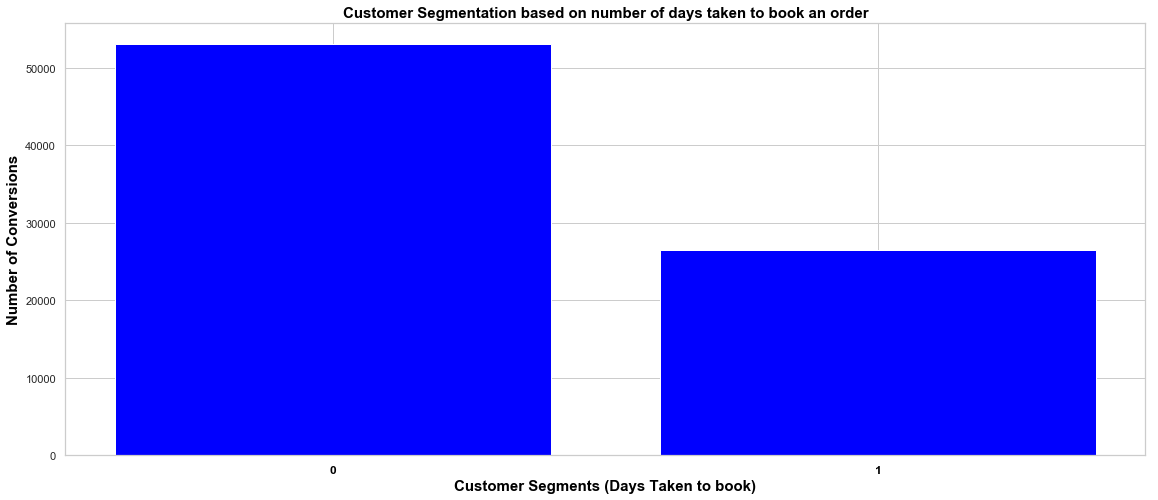

In [42]:
fig    = plt.figure(figsize=(15,6))
ax     = fig.add_axes([0,0,1,1])
x_axis = list(dict_number_of_days.keys())
y_axis = list(dict_number_of_days.values())
ax.bar(x_axis,y_axis,color='blue')
ax.set_xlabel('Customer Segments (Days Taken to book)',fontsize=15, weight = 'bold', color="black")
ax.set_ylabel('Number of Conversions',fontsize=15, weight = 'bold', color="black")
ax.set_title('Customer Segmentation based on number of days taken to book an order',fontsize=15, weight = 'bold', color="black")
plt.xticks(x_axis,fontsize=12, weight = 'bold', color="black")
plt.show()